# Redes Neurais
## 1ª Lista de Exercícios - Classificação de padrões


Estudante: Paloma Sette

Base de dados: breast_cancer

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<h1> Importante! </h1>

1. Fique atento com os hiperparâmetros iniciais desta lista. Dependendo do problema, os valores podem mudar. Para encontrar um conjunto de parâmetros razoáveis, siga o seguinte roteiro: 

        1. Rode os itens 2.1 e 3.1 com os parâmetros iniciais. Se os dois resultados foram igualmente ruins, modifique os parâmetros do item 3.1 até que o resultado seja relativamente melhor que o 2.1.

        2. Após obter esses melhores parâmetros iniciais, rode novamente o item 2.1 com os mesmos hiperparâmetros para uma comparação mais justa. 

2. O resultado de um modelo de Redes Neurais geralmente depende da inicialização de seus pesos. Portanto, para cada questão, obtenha um resultado médio de pelo menos 10 rodadas.

In [108]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
from time import sleep
import requests
from typing import Tuple, Dict, List
from tqdm.notebook import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from utils import CustomDataset, transform_data, plot_confusion_matrix
from model_utils import train, evaluate
from metrics import *

In [ ]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons) # camada oculta
    self.ha = self.activations[hidden_activation] # ativação da camada oculta
    self.fc2 = nn.Linear(hidden_neurons, n_output) # camada de saída
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h)
    y = self.fc2(h1)
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_(entendendo o código e ponderando o que já temos antes de dar início ao desenvolvimento)_

###  Temos de uma MLP modular flexível para instanciar RN's com: 
* Camada de entrada;
* 1 camada oculta com ativação personalizável;
* Camada de Saída;
* opção de ativaçao tambpem na saída.

| Parametro    | Função |
| -------- | ------- |
| `hidden_neurons`  | qtd de neuronios na camada oculta    |
| `hidden_activation` | função de ativação da camada oculta     |
| `output_activation`    | ativação na camada de saída que por enquanto está comentado    |
| `lr`                      | Taxa de aprendizado da rede         |
|`n_input`                        | numero de entradas (vai ser o tamanho do vetor X)         |
| `n_output`                       | Número de saídas (tipicamente 1 para binária)           |


Temos que:

```
self.fc1 = nn.Linear(n_input, hidden_neurons)
self.fc2 = nn.Linear(hidden_neurons, n_output)

```

ou seja:
* Primeira camada: entrada → camada oculta
* Segunda camada: camada oculta → saída

E ativação oculta:
```
self.ha = self.activations[hidden_activation]
```

### Está comentado mas pode ser usado:
```
# self.out = self.activations[output_activation]
# y = self.out(h2)
```
para quando quisermos aplicar uma função de ativação na saída.
Vai ser necessário se não usarmos uma _loss_ que já incorpora a ativação (por ex.: `BCEWithLogitsLoss`  ou `CrossEntropyLoss`)


### o método predict já vem com uma lógica embutida:
* ou seja, se for classificação binária ---> `y_pred = torch.round(torch.sigmoid(y_hat))` -->  aplica sigmoid na saída e arredonda

* se for multiclasse ----> `y_pred = torch.argmax(y_hat, dim=1)` --> pega o índice do maior valor (probabilidade mais alta)

### forward(x) --> caminho da previsão 
* pega um input x, passa pelas camadas, aplica as funções de ativação e devolve o output bruto da rede (mas ainda sem classificaçao aq)

### predict(x) --> transforma a saída bruta em resposta classificada
* é uma função personalizada feita para usarmos depois do treino quando a gente quiser ver a classificação final (0 ou 1, ou classe 1, 2, 3...)
* o que ela faz:
     * chama forward;
     * aplica uma função de ativação na saída se necessário;
     * aplica round() ou argmax() dependendo se o problema é binário ou multiclasse;
     * Converte pra numpy pra facilitar análise e uso externo.


## Preparação dos dados

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [22]:
dataset_name = 'breast_cancer'
# aqui eu dei uma modificada porque eu fiz o fork do repositório e clonei o meu fork :)
dataset_path =  f'https://raw.githubusercontent.com/palomaflsette/PUC_Redes_Neurais/main/datasets/c_{dataset_name}.csv'
info_path = f'https://raw.githubusercontent.com/palomaflsette/PUC_Redes_Neurais/main/datasets/data_info/{dataset_name}/data_info.json'
dataset = pd.read_csv(dataset_path)

In [23]:
resp = requests.get(info_path)
info = json.loads(resp.text)

In [24]:
for col, k in info.items():
    if k == 'categorical':
        dataset[col] = dataset[col].astype(object)

In [25]:
for i in dataset.dtypes.items():
    print(i)

('ID', dtype('O'))
('radius', dtype('float64'))
('texture', dtype('float64'))
('perimeter', dtype('float64'))
('area', dtype('float64'))
('smoothness', dtype('float64'))
('compacity', dtype('float64'))
('concavity', dtype('float64'))
('pts_concavity', dtype('float64'))
('symmetry', dtype('float64'))
('fractal', dtype('float64'))
('std_radius', dtype('float64'))
('std_texture', dtype('float64'))
('std_perimeter', dtype('float64'))
('std_area', dtype('float64'))
('std_smoothness', dtype('float64'))
('std_compacity', dtype('float64'))
('std_concavity', dtype('float64'))
('std_pts_concavity', dtype('float64'))
('std_symmetry', dtype('float64'))
('std_fractal', dtype('float64'))
('minor_radius', dtype('float64'))
('minor_texture', dtype('float64'))
('minor_perimeter', dtype('float64'))
('minor_area', dtype('float64'))
('minor_smoothness', dtype('float64'))
('minor_compacity', dtype('float64'))
('minor_concavity', dtype('float64'))
('minor_pts_concavity', dtype('float64'))
('minor_symmetry',

## Parte I - Compreensão do problema e análise de variáveis

Total: 2,0 pts.


### 1.1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

A varíável 'ID' não entrará no modelo.

além disso, temos que a nossa variavel alvo (`'target'`) está como dtype('o') (object) , então precisa ser convertida pra número, já podemos aproveitar para adiantar isso aqui nesta etapa.


In [26]:
dataset = dataset.drop(columns=['ID'])

In [32]:
le = LabelEncoder()
dataset['target'] = le.fit_transform(dataset['target'])

Transformamos:
* "benigno" --> 0
* "maligno" --> 1 (ou vice-versa porque o `le` define de forma automatica)

In [33]:
dataset.dtypes

radius                 float64
texture                float64
perimeter              float64
area                   float64
smoothness             float64
compacity              float64
concavity              float64
pts_concavity          float64
symmetry               float64
fractal                float64
std_radius             float64
std_texture            float64
std_perimeter          float64
std_area               float64
std_smoothness         float64
std_compacity          float64
std_concavity          float64
std_pts_concavity      float64
std_symmetry           float64
std_fractal            float64
minor_radius           float64
minor_texture          float64
minor_perimeter        float64
minor_area             float64
minor_smoothness       float64
minor_compacity        float64
minor_concavity        float64
minor_pts_concavity    float64
minor_symmetry         float64
minor_fractal          float64
target                   int64
dtype: object

#### Resposta

Após a inspeção do dataset, foi verificado que a variável `ID` pode (e deve) ser eliminada, pois é apenas um identificador único de cada instância e não possui valor preditivo. Como não representa nenhuma característica relevante para a classificação, sua presença pode introduzir ruído ou enviesar o modelo. As demais variáveis são características quantitativas relevantes para a predição do câncer de mama.

### 1.2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho

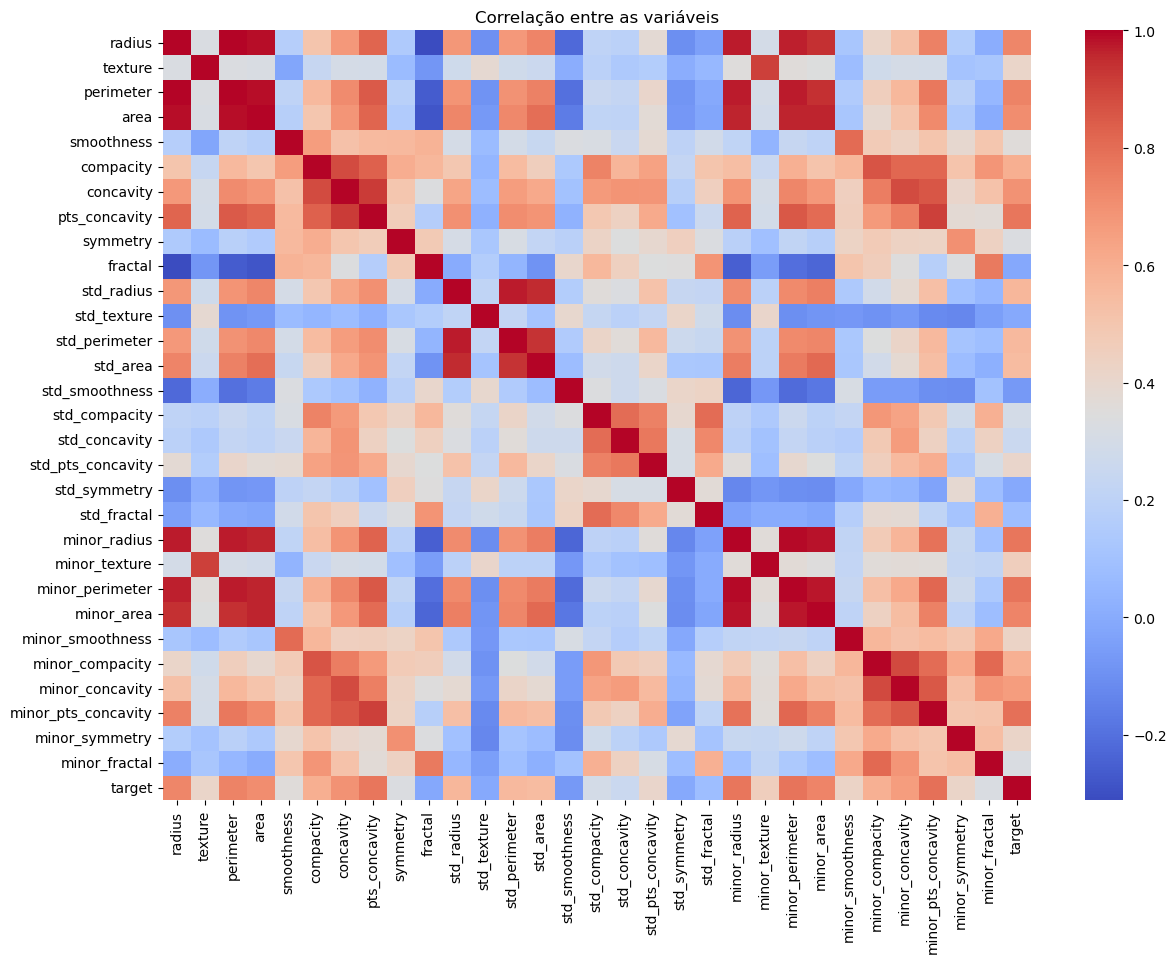

In [34]:
""" 
Podemos tentar o gráfico de correlação, que mostra a correlação entre as variáveis e ajuda a identificar redundâncias.
"""

plt.figure(figsize=(14, 10))
sns.heatmap(dataset.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Correlação entre as variáveis')
plt.show()

O gráfico mede o quanto uma variável muda quando a outra muda. --> valores entre -1 (inversamente correlacionado) e +1 (diretamente correlacionado)

por exemplo, As variáveis _area_ e _radius_ têm uma célula em vermelho escuro = forte correlação positiva.  Isso significa que quando o raio aumenta, a área aumenta, de forma quase linear. Isso faz sentido físico: área cresce com o quadrado do raio!

isso é interessante porque podemos identificar redundancias --> se _radius_, _area_, _perimeter_ estão muito fortemente correlacionadas, talvez não seja necessário usar todas elas como entrada na rede. Isso ajuda na redução da dimensinalidade (como PCA ou seleção de features)

In [35]:
### podmos ver as 5 variáveis mais correlacionadas com a variável alvo (target)

correlacoes = dataset.corr(numeric_only=True)[
    'target'].abs().sort_values(ascending=False)
top_variaveis = correlacoes.drop('target').head(5)
print(top_variaveis)

minor_pts_concavity    0.793566
minor_perimeter        0.782914
pts_concavity          0.776614
minor_radius           0.776454
perimeter              0.742636
Name: target, dtype: float64


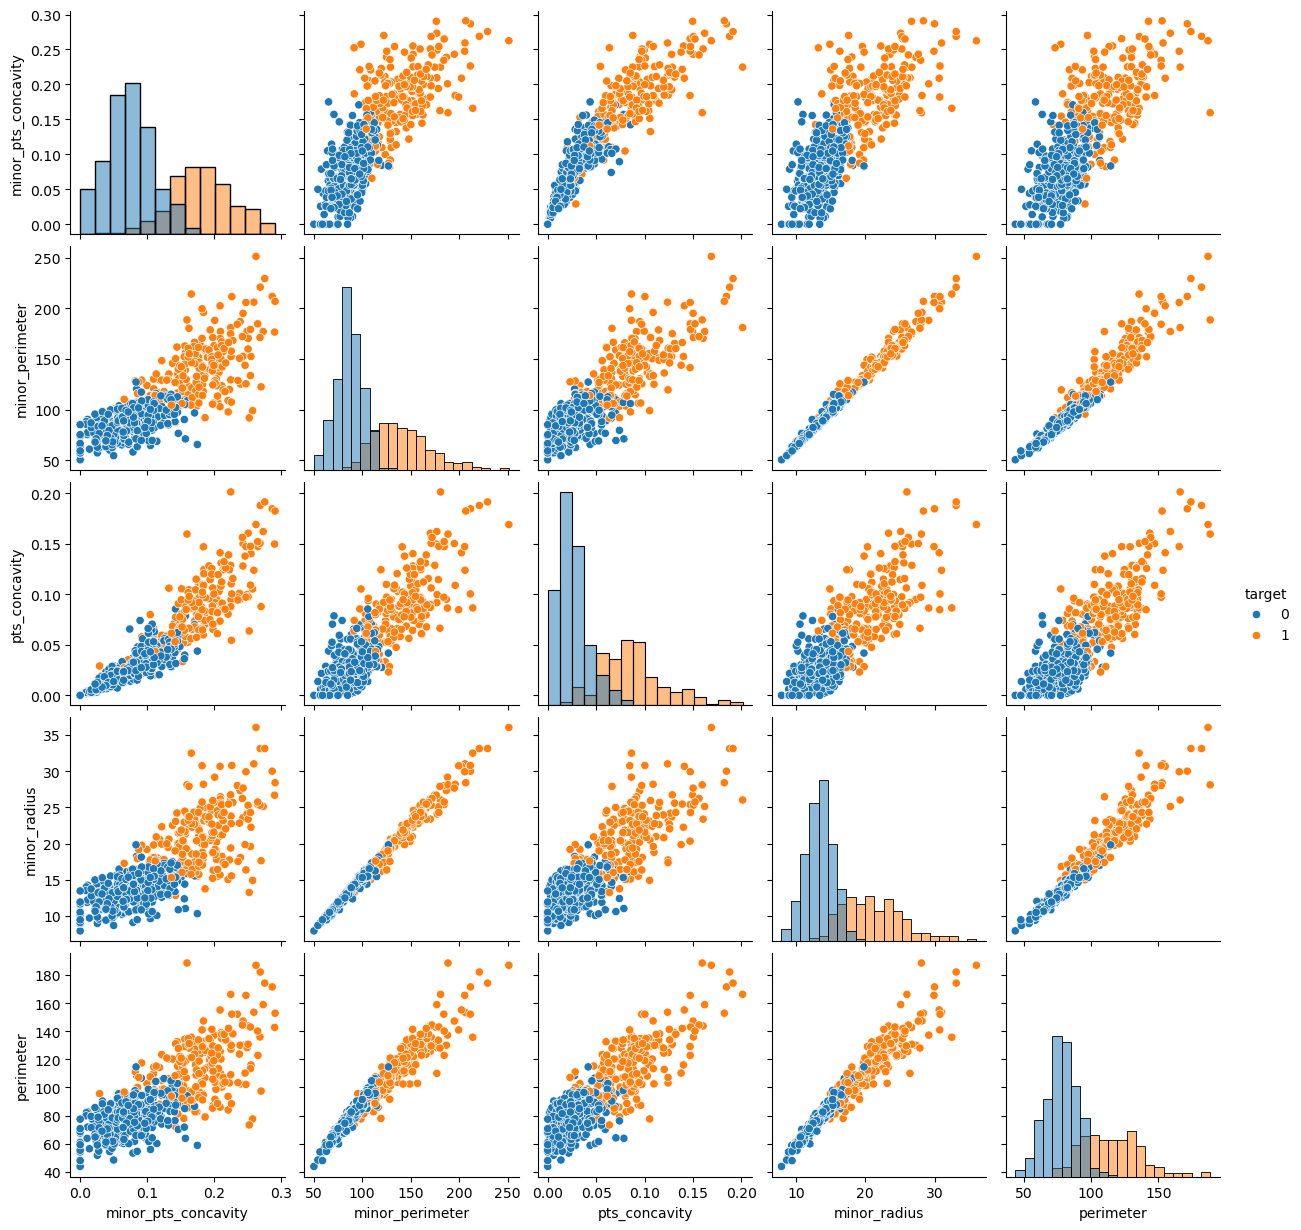

In [36]:
""" 
matriz de gráficos de dispersão (pairplot) para as 5 variáveis mais correlacionadas com a variável alvo (target)
"""
sns.pairplot(dataset[top_variaveis.index.tolist() +
             ['target']], hue='target', diag_kind='hist')

No eixo diagonal, temos as distribuições (kernel density). 
podemos analisar como a curva laranja está deslocada pra direita em todas as 5 variáveis. Isso indica que  tumores malignos (classe 1) tendem a ter valores maiores de:
* minor_pts_concavity
* minor_perimeter
* pts_concavity
* minor_radius
* perimeter

ou seja, essas variáveis ajudam fortemente a separar as classes.

Fora da diagonal, temos as dispersões bivariadas.
* as nuvens azuis e laranjas não se misturam muito, o que é um bom sinal.
* algumas relações (por ex: minor_radius vs perimeter) tem distribuição quase linear,  é fácil pro modelo aprender.
* isso indica que essas variáveis são deduntandes entre si, mas muito úteis para prever a classe.

Logo,

--> as 5 variáveis selecionadas tem alta correlação com a target;

--> elas mostram distribuições significativamente diferentes entre classes -> ótimo poder discriminativo;

--> existe forte correlação entre essas variáveis entre si, o que pode ser levado em conta para reduzir dimensionalidade com PCA ou seleção.

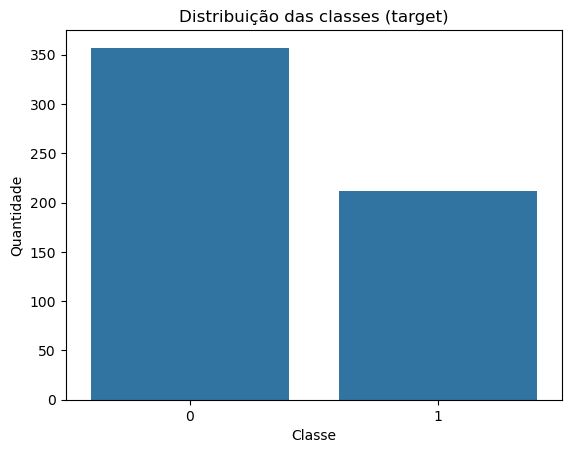

In [37]:
""" 
outra opção também é a distribuição da variável alvo (balanceamento)
"""
sns.countplot(x='target', data=dataset)
plt.title('Distribuição das classes (target)')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.show()

o que o gráfico mostra:

* Classe 0 (benignos): ~357 amostras
* Classe 1 (malignos): ~212 amostras

Total: 569 amostras


a base está moderadamente desbalanceada (aprox. 63% benigno, 37% maligno). Não é um desbalanceamento severo, então pode-se treinar o modelo normalmente.

Porém, seria bom acompanhar métricas além da acurácia (como precisão, recall e F1-score), especialmente pra classe 1 (malignos)

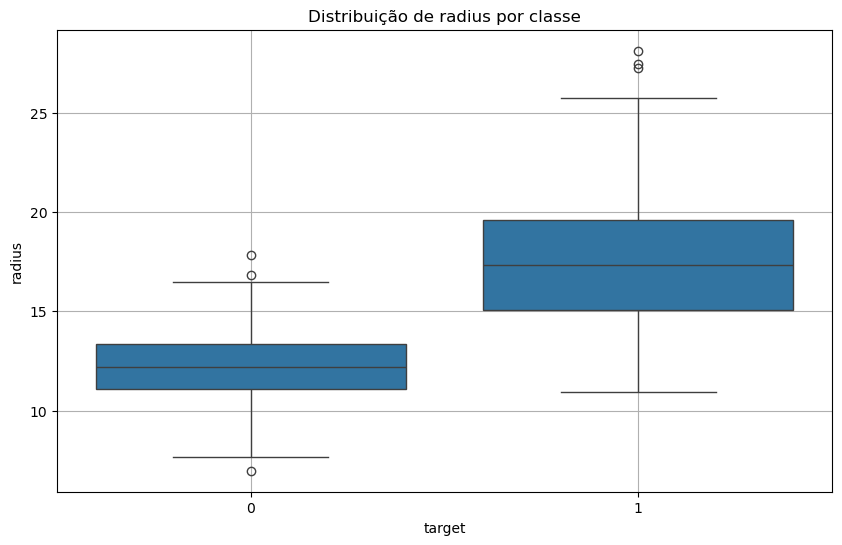

In [38]:
""" 
boxplot pr algumas variaveis relevantes por classe
"""

plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='radius', data=dataset)
plt.title('Distribuição de radius por classe')
plt.grid()
plt.show()

* Classe 0 (benignos):
     * Valor central (mediana) por volta de 12.5

     * Distribuição mais concentrada (caixa menor)

     * Alguns outliers abaixo de 8 e acima de 16

* Classe 1 (malignos):
     * Mediana por volta de 17.5

     * Distribuição mais espalhada

     * Valores muito mais altos (chegando a 27–28)

A variável radius tem alto poder discriminativo. Os malignos tendem a apresentar raios maiores, com mais variabilidade. Ela se mostrou uma excelente candidata para a entrada do modelo (feature importante). Pode ser usada até como ponto de corte preliminar numa regra simples

#### Resposta

Para extrair características importantes da base de dados `breast_cancer`, foram aplicadas diferentes técnicas de visualização:

1. **Mapa de calor de correlação (heatmap)**: permitiu observar quais variáveis estão fortemente relacionadas entre si e com a variável alvo `target`. Identificamos alta correlação entre atributos como `minor_pts_concavity`, `minor_perimeter` e `pts_concavity` com a classe do tumor, indicando que são excelentes candidatas para compor o modelo de classificação.

2. **Distribuição das classes (countplot)**: revelou que a base está levemente desbalanceada (aproximadamente 63% da classe 0 e 37% da classe 1), o que não inviabiliza o uso direto em modelos, mas exige atenção à avaliação com métricas mais robustas, como precisão e recall.

3. **Boxplot da variável `radius` por classe**: mostrou uma clara separação entre as distribuições das classes, evidenciando que tumores malignos tendem a apresentar valores de `radius` mais altos e dispersos do que os benignos. Isso confirma o potencial discriminativo dessa variável.

4. **Pairplot com as 5 variáveis mais correlacionadas com a `target`**: evidenciou visualmente que essas variáveis conseguem separar bem as classes, com nuvens de pontos pouco sobrepostas e distribuições distintas. Isso reforça seu valor preditivo e ajuda na seleção de variáveis mais relevantes.

Essas técnicas foram escolhidas por sua capacidade de revelar relações estruturais, padrões de separabilidade e potenciais redundâncias entre atributos. A partir dessas análises, é possível refinar a seleção de variáveis e orientar a construção de modelos preditivos mais eficazes.


## Parte II. Treinamento do modelo de Rede Neural - Baseline 

Total: 1,0 pts.

### 2.1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

Como o enunciado pede para que consideremos as configurações previamente definidas do modelo MLP, significa que não devemos alterar a estrutura da classe `NeuralNetwork`. Neste caso, vamos usar esta arquitetura MLP já codificada. Então, podemos ponderar:

DEFINIÇÕES:
* Uma camada de entrada com `n_input` neurônios;
* Uma ou mais camadas ocultas com função  de atuvação ReLU;
* Uma camada de saída com `sigmoid` (já que a classificação é binária);
* A função de perda usada provavelmente é `BCEWithLogitsLoss`. 

TREINAMENTO SEM NORMALIZAR OS ATRIBUTOS:
* Por padrão, sabemos que as redes neurais funcionam melhor com entradas normalizadas ou padronizadas.
* No entanto, aqui não iremos normalizar (manteremos `normalize=False`)
* Isso vai provocar dificuldade no aprendizado porque os valores numéricos estão em escalas diferentes.

No fim, iremos avaliar a qualidade do modelo com as métricas

Métrica | O que mede | Quando é útil
--------|------------|--------------
Acurácia| Proporção de acertos totais | quando as classes estão balanceadas
Precision | Quantos dos que foram classificados como 1 realmente são 1 | Quando o erro falso positivo é mais grave.
Recall | Quantos dos verdadeiros 1 foram realmente identificados | Quando o erro falso negativo é mais grave.
F1-Score | Média harmônica entre precision e recall. | Quando há desequilíbrio de classes.
Matriz de confusão | Mostra a distribuição dos acertos e erros para cada classe. | Visualemnte ajuda a entender o comportamento da rede.

##### 2.1.1)  Segunda Etapa da Preparação dos Dados

In [39]:
new_df = transform_data(dataset, normalize=False)
#new_df.head() 

In [42]:
new_df.head()

,radius,texture,perimeter,area,smoothness,compacity,concavity,pts_concavity,symmetry,fractal,...,minor_texture,minor_perimeter,minor_area,minor_smoothness,minor_compacity,minor_concavity,minor_pts_concavity,minor_symmetry,minor_fractal,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [ ]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Binary classification


In [43]:
batch_size = 32 
epochs = 170

In [ ]:
""" 
Separando os dados em treino, validação e teste
"""
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [45]:
X_train

array([[1.464e+01, 1.524e+01, 9.577e+01, ..., 1.397e-01, 3.151e-01,
        8.473e-02],
       [1.522e+01, 3.062e+01, 1.034e+02, ..., 2.356e-01, 4.089e-01,
        1.409e-01],
       [1.371e+01, 1.868e+01, 8.873e+01, ..., 1.284e-01, 2.849e-01,
        9.031e-02],
       ...,
       [1.270e+01, 1.217e+01, 8.088e+01, ..., 8.224e-02, 2.775e-01,
        9.464e-02],
       [1.460e+01, 2.329e+01, 9.397e+01, ..., 1.359e-01, 2.477e-01,
        6.836e-02],
       [1.267e+01, 1.730e+01, 8.125e+01, ..., 5.602e-02, 2.688e-01,
        6.888e-02]])

In [ ]:

#Para o caso de múltiplas classes
#train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
#val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
#test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
""" 
Preparação dos Dados para Treinamento no PyTorch
"""
if binary:
    # convertendo para tensores
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    # convertendo para tensores
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

# tensor ---> dataloader
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [49]:
train_dataset.X_data

tensor([[1.4640e+01, 1.5240e+01, 9.5770e+01,  ..., 1.3970e-01, 3.1510e-01,
         8.4730e-02],
        [1.5220e+01, 3.0620e+01, 1.0340e+02,  ..., 2.3560e-01, 4.0890e-01,
         1.4090e-01],
        [1.3710e+01, 1.8680e+01, 8.8730e+01,  ..., 1.2840e-01, 2.8490e-01,
         9.0310e-02],
        ...,
        [1.2700e+01, 1.2170e+01, 8.0880e+01,  ..., 8.2240e-02, 2.7750e-01,
         9.4640e-02],
        [1.4600e+01, 2.3290e+01, 9.3970e+01,  ..., 1.3590e-01, 2.4770e-01,
         6.8360e-02],
        [1.2670e+01, 1.7300e+01, 8.1250e+01,  ..., 5.6020e-02, 2.6880e-01,
         6.8880e-02]])

In [50]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [51]:
lr = 0.01
epochs = 250

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.984 | Val Loss: 0.6760 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 002: | Train Loss: 0.670 | Val Loss: 0.6756 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 003: | Train Loss: 0.669 | Val Loss: 0.6752 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 004: | Train Loss: 0.668 | Val Loss: 0.6748 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 005: | Train Loss: 0.668 | Val Loss: 0.6745 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 006: | Train Loss: 0.667 | Val Loss: 0.6742 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 007: | Train Loss: 0.667 | Val Loss: 0.6739 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 008: | Train Loss: 0.666 | Val Loss: 0.6736 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 009: | Train Loss: 0.666 | Val Loss: 0.6734 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 010: | Train Loss: 0.665 | Val Loss: 0.6731 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 011: | Train Loss: 0.665 | Val Loss: 0.6729 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 012: | Train Lo

In [52]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        71
           1       0.00      0.00      0.00        43

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



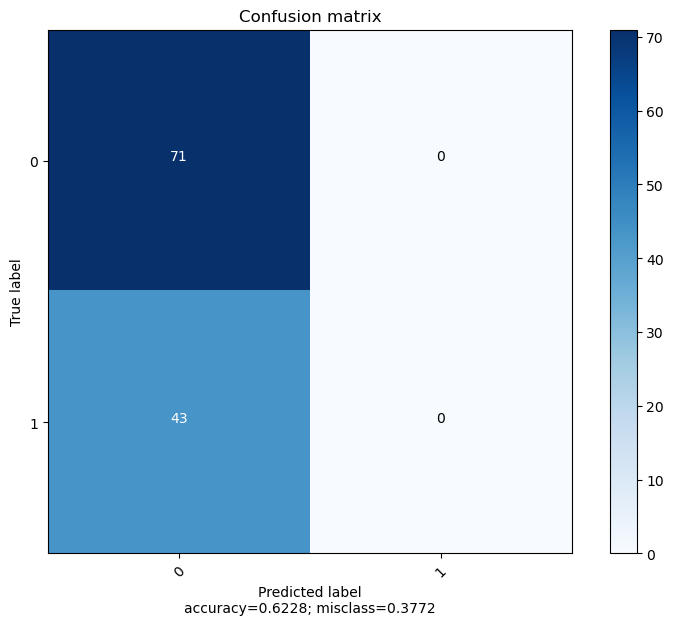

In [53]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Resposta

##### ANALISANDO OS RESULTADOS DAS EXECUÇÕES ACIMA
* Acurácia final: `0.62` ---> apenas 62% dos exemplos do teste foram classificados corretamente.
* Precision da classe 0: `0.62` (classe majoritária)
* Recall da classe 1: `0.00` ---> o modelo não conseguiu identificar nenhum caso da classe 1.
* F1 da classe 1: `0.00` ---> reflexo direto da ausência de _true positives_.

Isso indica que o modelo aprendeu sempre a prever a classe 0, ignorando a classe 1.

##### POSSÍVEIS RAZÕES PARA O MAU DESEMPENHO DO MODELO
1. Ausência de normalização:
     * Os atributos possuem escalas diferentes. Isso prejudica a aprendizagem, pois os gradientes ficam desbalanceados.
2. Problema de classe desbalanceada:
     * A classe 0 é mais frequente no conjunto.
     * A rede pode estar minimizando o erro aprendendo a sempre prever a classe dominante, principalmente quando os pesos iniciais não favorecem distinções.
3. Rede rasa e simples:
     * Apenas 1 camada oculta com poucos neurônios.
     * Sem normalização e com dados brutos, essa estrutura pode não ter capacidade para aprender distinções sutis.

Portanto,
o treinamento da rede neural sem normalizar os atributos resultou em um desempenho insatisfatório. A acurácia foi de apenas 62% e o modelo foi incapaz de identificar corretamente qualquer exemplo da classe 1, como evidenciado pelo recall e F1-score igual a 0 para essa classe. A matriz de confusão mostra que todos os exemplos foram classificados como pertencentes à classe 0. Isso ocorre provavelmente devido à falta de normalização das entradas, o que impede o bom funcionamento do gradiente de descida, além do desbalanceamento entre as classes e da baixa complexidade da rede. Esses fatores combinados impedem o aprendizado de padrões relevantes.


## Parte III - Mudança de configurações do modelo

Total: 5,0 pts.

### 3.1)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho

In [54]:
new_df = transform_data(dataset, normalize=True)
new_df.head()

,radius,texture,perimeter,area,smoothness,compacity,concavity,pts_concavity,symmetry,fractal,...,minor_texture,minor_perimeter,minor_area,minor_smoothness,minor_compacity,minor_concavity,minor_pts_concavity,minor_symmetry,minor_fractal,target
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,1
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,1
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,1
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,1
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,1


In [55]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification


In [56]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [57]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.786 | Val Loss: 0.7651 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 002: | Train Loss: 0.773 | Val Loss: 0.7556 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 003: | Train Loss: 0.763 | Val Loss: 0.7478 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 004: | Train Loss: 0.755 | Val Loss: 0.7411 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 005: | Train Loss: 0.748 | Val Loss: 0.7351 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 006: | Train Loss: 0.742 | Val Loss: 0.7297 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 007: | Train Loss: 0.736 | Val Loss: 0.7247 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 008: | Train Loss: 0.731 | Val Loss: 0.7200 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 009: | Train Loss: 0.726 | Val Loss: 0.7157 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 010: | Train Loss: 0.721 | Val Loss: 0.7118 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 011: | Train Loss: 0.716 | Val Loss: 0.7081 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 012: | Train Lo

#### Resposta

In [58]:
y_pred = model.predict(test_dataset.X_data,binary=binary)


              precision    recall  f1-score   support

           0       0.89      1.00      0.94        71
           1       1.00      0.79      0.88        43

    accuracy                           0.92       114
   macro avg       0.94      0.90      0.91       114
weighted avg       0.93      0.92      0.92       114



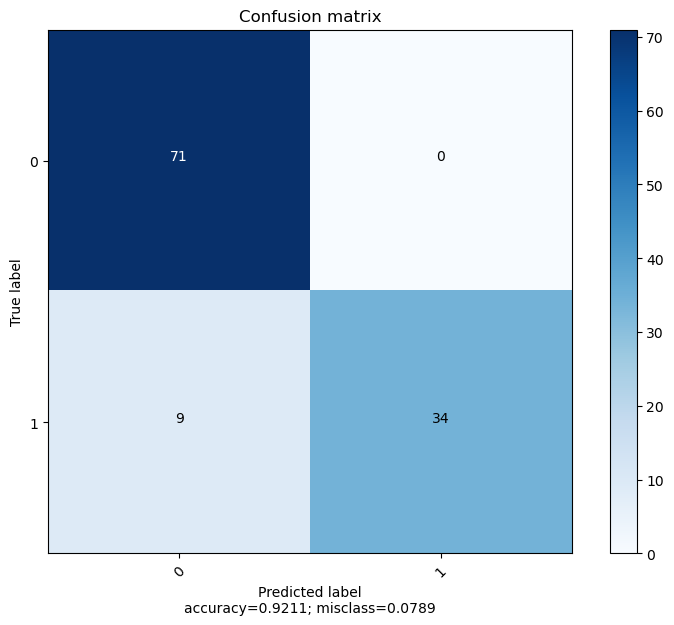

In [59]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

O QUE FOI FEITO NA QUESTÃO 3.1:
* Aplicamos a normalização nas variáveis de entrada (`normalize=True`);
* Mantivemos o modelo MLP com a mesma estrutura e hiperparâmetros da parte anterior;
* Treinamos novamente com 250 épocas e taxa de aprendizado de 0.01.

----------
COMPARANDO OS RESULTADOS

Métrica | Sem normalização | Com Normalização
--------|------------------|-----------------|
Acurácia | 0.62            | 0.92
Precision (classe 1) | 0.00 | 1.00
Recall (classe 1) | 0.00    | 0.79
F1-Score (casse 1) | 0.00   | 0.88
Matriz de Confusão | Predominava 0 | Boa separação 0 e 1

--------
INTERPRETAÇÃO DO EFEITO DA NORMALIZAÇÃO
1. Convergência e aprendizado real:

     * Sem normalização: o modelo não conseguia sair de uma zona de conforto, ficava preso em um mínimo ruim com loss estável, acurácia constante (~50-60%) e output colapsado para uma só classe.

     * Com normalização: o modelo finalmente conseguiu aprender, reduzindo loss e aumentando acurácia e recall, principalmente da classe minoritária.

2. Impacto nos pesos e gradientes:

     * Com atributos em escalas muito diferentes, os gradientes explodem ou somem.

     * A normalização traz tudo para a mesma escala (0 a 1), o que permite atualizações consistentes dos pesos com backpropagation.

3. Efeito sobre a função de ativação:

     * ReLU ou Sigmoid tendem a saturar com entradas muito grandes ou pequenas. A normalização evita isso, mantendo os dados na faixa ideal das ativações.

-----------

CONCLUSÃO

Portanto, a normalização foi decisiva para o modelo MLP funcionar corretamente. Ela aumentou a capacidade de generalização, possibilitou a aprendizagem de padrões reais e corrigiu o colapso de classe (modelo que só previa 0). Sem normalizar, o modelo falhava ao aprender, mesmo com 250 épocas e taxa de 0.01.
Com a normalização, o modelo treinou bem e teve performance sólida (accuracy 92%, f1-score 88%).

### 3.2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.

#### Rascunho

##### 3.2.1)  Treinando com 1 (uma) Epoch (subtreinamento)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.661 | Val Loss: 0.6710 | Train Acc: 63.1667| Val Acc: 60.0000
Resultados com 1 época:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        71
           1       0.00      0.00      0.00        43

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

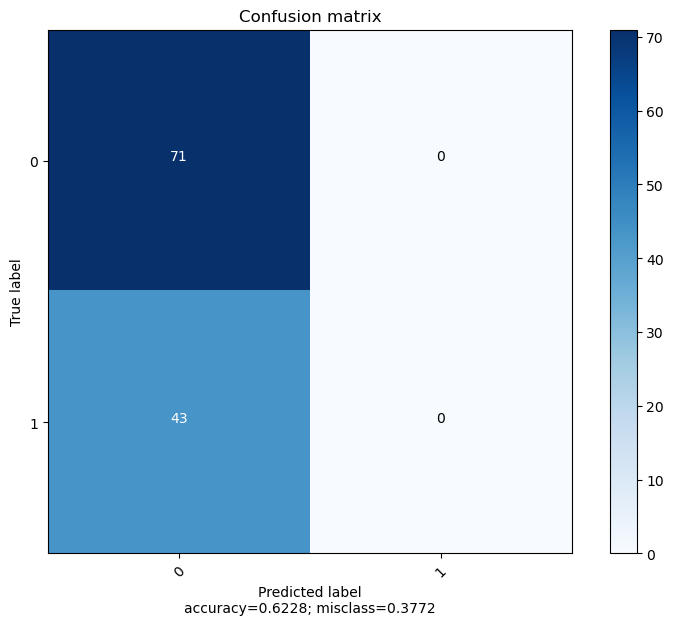

In [70]:
epochs = 1
model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset,
                       epochs=epochs, lr=lr, device=device, binary=binary)

y_pred = model.predict(test_dataset.X_data, binary=binary)
print("Resultados com 1 época:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

##### 3.2.2) Treinando com 1000 (mil) Epochs (risco de sobreajuste)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.657 | Val Loss: 0.6598 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 002: | Train Loss: 0.655 | Val Loss: 0.6576 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 003: | Train Loss: 0.652 | Val Loss: 0.6556 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 004: | Train Loss: 0.650 | Val Loss: 0.6537 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 005: | Train Loss: 0.648 | Val Loss: 0.6520 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 006: | Train Loss: 0.646 | Val Loss: 0.6504 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 007: | Train Loss: 0.644 | Val Loss: 0.6489 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 008: | Train Loss: 0.643 | Val Loss: 0.6474 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 009: | Train Loss: 0.641 | Val Loss: 0.6461 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 010: | Train Loss: 0.640 | Val Loss: 0.6448 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 011: | Train Loss: 0.638 | Val Loss: 0.6435 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 012: | Train Lo

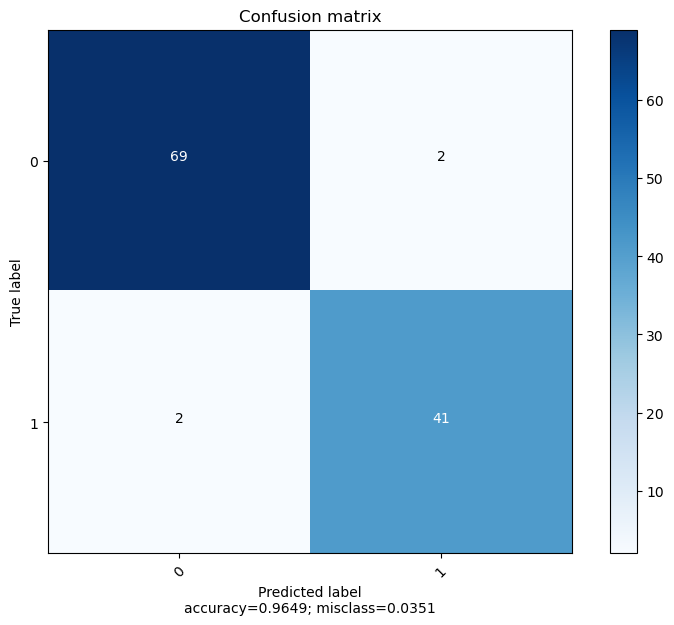

In [68]:
epochs = 1000
model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset,
                       epochs=epochs, lr=lr, device=device, binary=binary)

y_pred = model.predict(test_dataset.X_data, binary=binary)
print("Resultados com 1000 épocas:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

##### 3.2.3) Treinando com 100 (cem) Epochs [comum para MLP simples]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.723 | Val Loss: 0.7160 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 002: | Train Loss: 0.715 | Val Loss: 0.7094 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 003: | Train Loss: 0.708 | Val Loss: 0.7038 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 004: | Train Loss: 0.702 | Val Loss: 0.6991 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 005: | Train Loss: 0.697 | Val Loss: 0.6950 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 006: | Train Loss: 0.692 | Val Loss: 0.6913 | Train Acc: 37.5833| Val Acc: 40.0000
Epoch 007: | Train Loss: 0.688 | Val Loss: 0.6879 | Train Acc: 41.2500| Val Acc: 47.0000
Epoch 008: | Train Loss: 0.684 | Val Loss: 0.6847 | Train Acc: 54.0833| Val Acc: 63.0000
Epoch 009: | Train Loss: 0.681 | Val Loss: 0.6817 | Train Acc: 70.1667| Val Acc: 73.0000
Epoch 010: | Train Loss: 0.677 | Val Loss: 0.6789 | Train Acc: 79.0833| Val Acc: 78.0000
Epoch 011: | Train Loss: 0.674 | Val Loss: 0.6761 | Train Acc: 82.1667| Val Acc: 82.0000
Epoch 012: | Train Lo

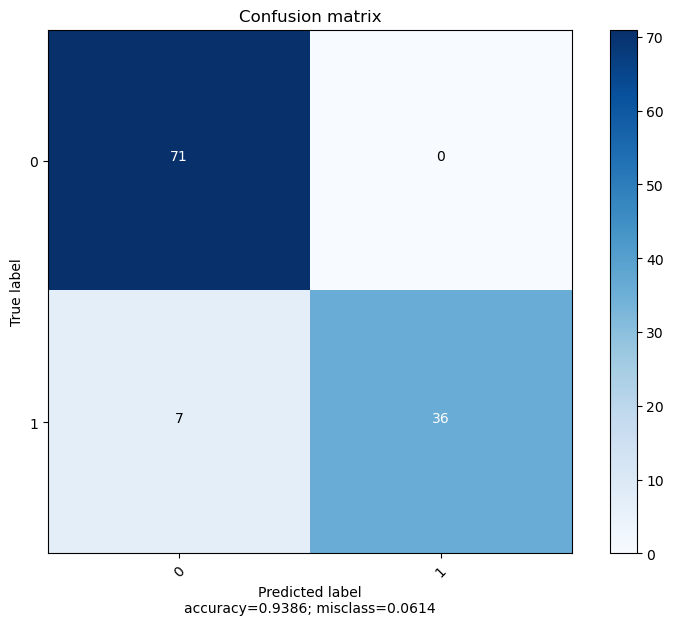

In [79]:
epochs = 100
model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset,
                       epochs=epochs, lr=lr, device=device, binary=binary)

y_pred = model.predict(test_dataset.X_data, binary=binary)
print("Resultados com 1000 épocas:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Resposta

RESUMO DOS EXPERIMENTOS

Treinamos o modelo com os seguintes números de épocas:

* 1 época --------> Acurácia: 62.28%
* 100 épocas -----> Acurácia 93.83% (mas com variação observada em outras execuções)
* 1000 épocas ----> Acurácia: 96.49%

ANALISANDO CRITICAMENTE

* 1 Época:
     * Desempenho ruim.

     * Matriz de confusão mostra que a rede só acertou a classe 0, não aprendendo nada sobre a classe 1.

     * Isso indica que não houve tempo suficiente para o modelo aprender padrões significativos nos dados.

     * A perda provavelmente ainda estava alta.

* 100 Épocas:
     * Em uma execução, apresentou desempenho excelente, com acurácia de 96,49%, classificando corretamente quase todos os exemplos.

     * No entanto, execuções subsequentes mostraram grande variabilidade, com acurácias variando entre ~62% e ~96%.

     * Isso evidencia que, embora 100 épocas possam ser suficientes, o resultado depende fortemente da inicialização dos pesos e da ordem dos dados durante o treinamento.

* 1000 Épocas:
     * Desempenho praticamente idêntico à melhor execução de 100 épocas.

     * A convergência já havia ocorrido antes da época 100, e o aumento não trouxe ganhos reais.

     * Porém, os resultados foram mais consistentes, indicando maior estabilidade do aprendizado com mais iterações.

-------------

Em suma, a variação no número de épocas teve impacto significativo no desempenho da rede. Com apenas 1 época, o modelo não teve tempo para aprender. Com 100 épocas, o desempenho pode ser excelente, mas não é garantido devido à aleatoriedade envolvida no treinamento. Com 1000 épocas, a acurácia se estabilizou e mostrou-se mais robusta a essas variações. 
Podemos refletir que os resultados para 100 épocas variam devido a diversos fatores. Por exemplo, inicialização aleatória dos pesos (cada vez que a rede é treinada, os pesos são inicializados de forma diferente, a menos que definamos um `random_seed`), ordem de entrada dos dados (shuffle - O DataLoader do PyTorch costuma embaralhar os dados entre epochs, o que influencia o gradiente e o caminho da otimização) e curva de aprendizado sensível (como o modelo é simples, com apenas uma camada escondida, e o número de épocas não é muito alto, flutuações naturais nos dados podem levar o otimizador a mínimos locias diferentes).

Para evitar instabilidade, é recomendável usar épocas maiores (como 250 a 1000), ou ainda fixar a semente aleatória para garantir reprodutibilidade.


### 3.3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.

#### Rascunho

##### 3.3.1) Treinando com learning rate = 0.001
Provável convergência lenta e segura aqui.

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.681 | Val Loss: 0.6907 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 002: | Train Loss: 0.681 | Val Loss: 0.6906 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 003: | Train Loss: 0.681 | Val Loss: 0.6905 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 004: | Train Loss: 0.680 | Val Loss: 0.6904 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 005: | Train Loss: 0.680 | Val Loss: 0.6902 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 006: | Train Loss: 0.680 | Val Loss: 0.6901 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 007: | Train Loss: 0.680 | Val Loss: 0.6900 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 008: | Train Loss: 0.680 | Val Loss: 0.6899 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 009: | Train Loss: 0.680 | Val Loss: 0.6897 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 010: | Train Loss: 0.680 | Val Loss: 0.6896 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 011: | Train Loss: 0.680 | Val Loss: 0.6895 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 012: | Train Lo

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

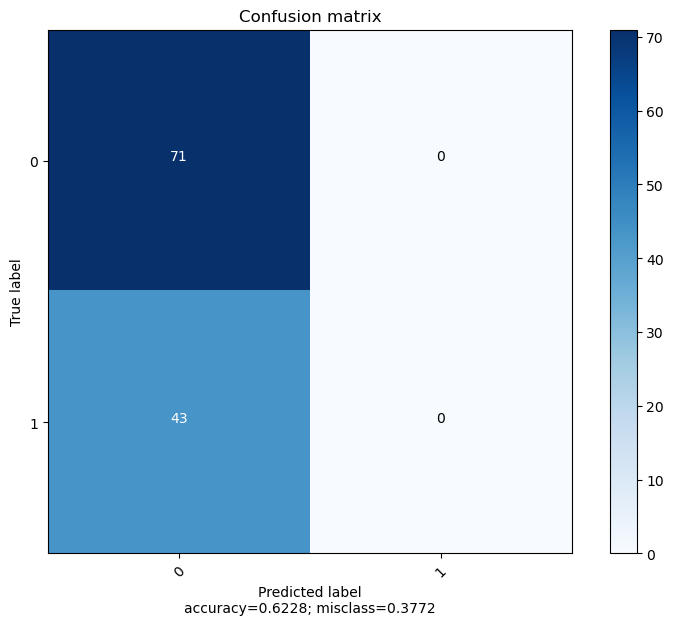

In [81]:
lr = 0.001
epochs = 250

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset,
                       epochs=epochs, lr=lr, device=device, binary=binary)

y_pred = model.predict(test_dataset.X_data, binary=binary)

print("Learning Rate = 0.001")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

##### 3.3.2)  Treinando com learning rate = 0.05
Convergência rápida e estável.

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.722 | Val Loss: 0.7075 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 002: | Train Loss: 0.703 | Val Loss: 0.6922 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 003: | Train Loss: 0.687 | Val Loss: 0.6788 | Train Acc: 65.4167| Val Acc: 79.0000
Epoch 004: | Train Loss: 0.674 | Val Loss: 0.6688 | Train Acc: 71.3333| Val Acc: 63.0000
Epoch 005: | Train Loss: 0.664 | Val Loss: 0.6604 | Train Acc: 65.9167| Val Acc: 60.0000
Epoch 006: | Train Loss: 0.655 | Val Loss: 0.6529 | Train Acc: 65.1667| Val Acc: 60.0000
Epoch 007: | Train Loss: 0.647 | Val Loss: 0.6457 | Train Acc: 65.1667| Val Acc: 60.0000
Epoch 008: | Train Loss: 0.639 | Val Loss: 0.6382 | Train Acc: 65.1667| Val Acc: 63.0000
Epoch 009: | Train Loss: 0.630 | Val Loss: 0.6300 | Train Acc: 65.6667| Val Acc: 63.0000
Epoch 010: | Train Loss: 0.621 | Val Loss: 0.6210 | Train Acc: 66.7500| Val Acc: 63.0000
Epoch 011: | Train Loss: 0.612 | Val Loss: 0.6110 | Train Acc: 68.0833| Val Acc: 66.0000
Epoch 012: | Train Lo

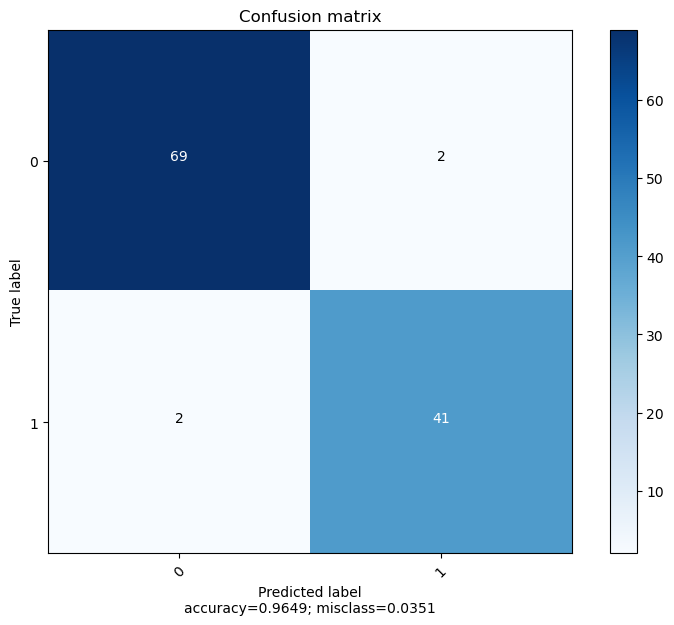

In [86]:
lr = 0.05
epochs = 250

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset,
                       epochs=epochs, lr=lr, device=device, binary=binary)

y_pred = model.predict(test_dataset.X_data, binary=binary)

print("Learning Rate = 0.01")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

##### 3.3.3) Treinando com learning rate = 0.1
Convergência instável e explosiva.

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.749 | Val Loss: 0.7211 | Train Acc: 24.5833| Val Acc: 14.0000
Epoch 002: | Train Loss: 0.710 | Val Loss: 0.6989 | Train Acc: 52.2500| Val Acc: 60.0000
Epoch 003: | Train Loss: 0.686 | Val Loss: 0.6818 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 004: | Train Loss: 0.667 | Val Loss: 0.6648 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 005: | Train Loss: 0.648 | Val Loss: 0.6468 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 006: | Train Loss: 0.628 | Val Loss: 0.6295 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 007: | Train Loss: 0.610 | Val Loss: 0.6132 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 008: | Train Loss: 0.593 | Val Loss: 0.5980 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 009: | Train Loss: 0.576 | Val Loss: 0.5826 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 010: | Train Loss: 0.559 | Val Loss: 0.5669 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 011: | Train Loss: 0.541 | Val Loss: 0.5507 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 012: | Train Lo

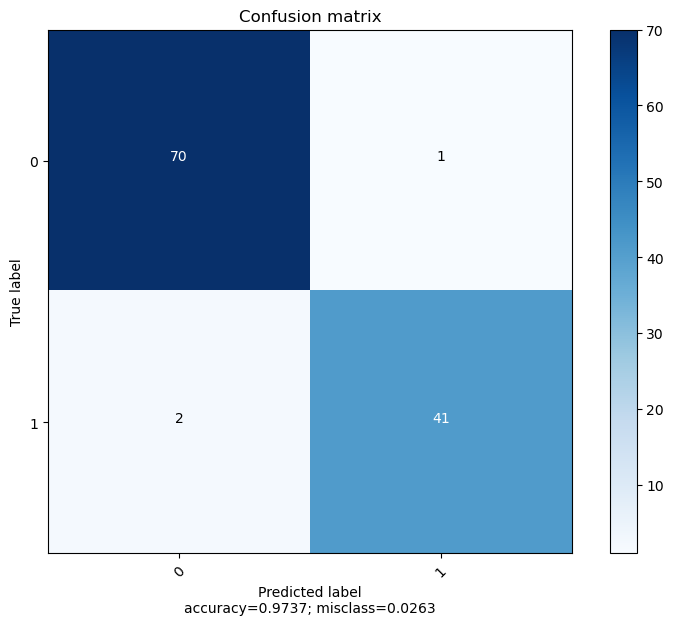

In [88]:
lr = 0.1
epochs = 250

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset,
                       epochs=epochs, lr=lr, device=device, binary=binary)

y_pred = model.predict(test_dataset.X_data, binary=binary)

print("Learning Rate = 0.1")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

#### Resposta

RESUMO DOS EXPERIMENTOS

Treinamos o modelo por 250 épocas, variando a taxa de aprendizado (`lr`) entre:
* 0.001 ---> acurácia de 62.28%
* 0.05 ----> acurácia de 96.49%
* 0.1 -----> acurácia de 97.37% 

ANÁLISE CRÍTICA

* Taxa de aprendizado 0.001:

     * Desempenho muito ruim, com acurácia de apenas 62.28%.

     * A matriz de confusão mostra que o modelo não aprendeu a distinguir a classe 1 (zero acertos nessa classe).

     * Indica convergência extremamente lenta, com pesos ainda mal ajustados após 250 épocas.

* Taxa de aprendizado 0.05:

     * Desempenho excelente, com acurácia de 96.49%.

     * Matriz de confusão equilibrada, mostrando que a rede aprendeu bem ambas as classes.

     * Modelo convergiu de forma eficiente, com boa generalização.

* Taxa de aprendizado 0.1:

     * Melhor desempenho registrado, com acurácia de 97.37%.

     * Matriz de confusão ainda mais precisa, com apenas 3 erros totais.

     * Aprendizado rápido e eficaz, sem sinais de instabilidade.

-------------

A taxa de aprendizado tem impacto decisivo no desempenho da rede neural. Valores muito baixos (como 0.001) podem resultar em subapredizado, mesmo com muitas épocas. Taxas moderadas a altas (como 0.05 e 0.1) favoreceram convergência rápida e alto desempenho.

Entre os valores testados, 0.1 foi o melhor, mas 0.05 também se mostrou estável e confiável, sendo uma escolha segura em contextos mais sensíveis a oscilações.

### 3.4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.

#### Rascunho

##### 3.4.1) Treinamento com `hidden_neurons = 2`

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.650 | Val Loss: 0.6632 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 002: | Train Loss: 0.648 | Val Loss: 0.6614 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 003: | Train Loss: 0.647 | Val Loss: 0.6596 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 004: | Train Loss: 0.645 | Val Loss: 0.6578 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 005: | Train Loss: 0.644 | Val Loss: 0.6560 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 006: | Train Loss: 0.642 | Val Loss: 0.6543 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 007: | Train Loss: 0.640 | Val Loss: 0.6526 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 008: | Train Loss: 0.639 | Val Loss: 0.6508 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 009: | Train Loss: 0.637 | Val Loss: 0.6491 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 010: | Train Loss: 0.635 | Val Loss: 0.6473 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 011: | Train Loss: 0.634 | Val Loss: 0.6456 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 012: | Train Lo

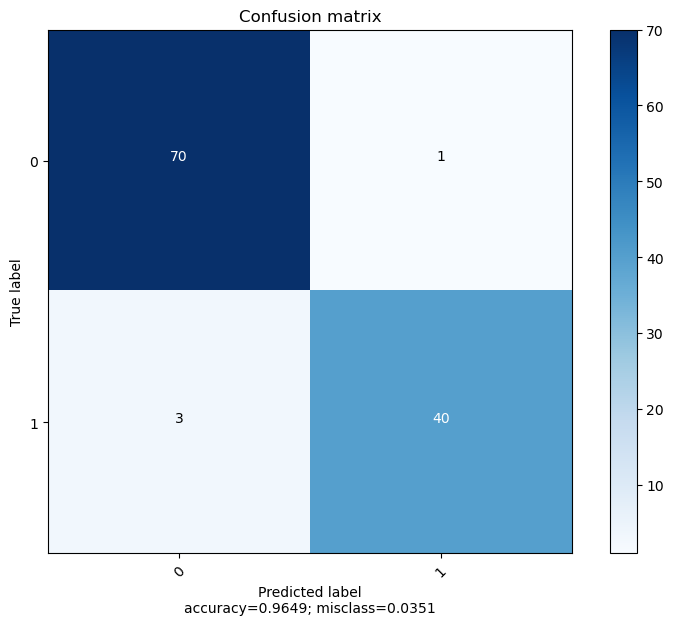

In [101]:
model = NeuralNetwork(n_input=n_input, n_output=n_output, hidden_neurons=2, output_activation='sigmoid')

history, y_hat = train(
    model,
    train_loader,
    val_dataset,
    epochs=250,
    lr=0.01,
    device=device,
    binary=binary
)

y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

##### 3.4.2) Treinamento com `hidden_neurons = 20`

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.696 | Val Loss: 0.6939 | Train Acc: 39.1667| Val Acc: 46.0000
Epoch 002: | Train Loss: 0.693 | Val Loss: 0.6918 | Train Acc: 44.2500| Val Acc: 51.0000
Epoch 003: | Train Loss: 0.691 | Val Loss: 0.6898 | Train Acc: 60.1667| Val Acc: 64.0000
Epoch 004: | Train Loss: 0.689 | Val Loss: 0.6879 | Train Acc: 67.0833| Val Acc: 65.0000
Epoch 005: | Train Loss: 0.686 | Val Loss: 0.6861 | Train Acc: 64.1667| Val Acc: 60.0000
Epoch 006: | Train Loss: 0.684 | Val Loss: 0.6844 | Train Acc: 63.6667| Val Acc: 60.0000
Epoch 007: | Train Loss: 0.682 | Val Loss: 0.6828 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 008: | Train Loss: 0.680 | Val Loss: 0.6813 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 009: | Train Loss: 0.678 | Val Loss: 0.6798 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 010: | Train Loss: 0.677 | Val Loss: 0.6784 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 011: | Train Loss: 0.675 | Val Loss: 0.6771 | Train Acc: 63.1667| Val Acc: 60.0000
Epoch 012: | Train Lo

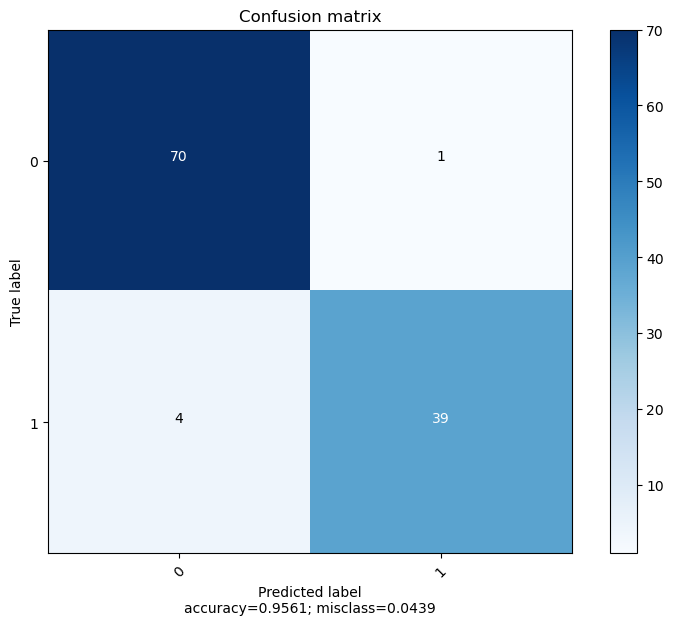

In [102]:
model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      hidden_neurons=20, output_activation='sigmoid')

history, y_hat = train(
    model,
    train_loader,
    val_dataset,
    epochs=250,
    lr=0.01,
    device=device,
    binary=binary
)

y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

##### 3.4.3) Treinamento com `hidden_size = 70`

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.691 | Val Loss: 0.6869 | Train Acc: 36.8333| Val Acc: 40.0000
Epoch 002: | Train Loss: 0.687 | Val Loss: 0.6833 | Train Acc: 38.0833| Val Acc: 44.0000
Epoch 003: | Train Loss: 0.682 | Val Loss: 0.6799 | Train Acc: 54.5000| Val Acc: 76.0000
Epoch 004: | Train Loss: 0.678 | Val Loss: 0.6767 | Train Acc: 78.7500| Val Acc: 86.0000
Epoch 005: | Train Loss: 0.675 | Val Loss: 0.6737 | Train Acc: 91.5833| Val Acc: 91.0000
Epoch 006: | Train Loss: 0.671 | Val Loss: 0.6708 | Train Acc: 89.8333| Val Acc: 91.0000
Epoch 007: | Train Loss: 0.668 | Val Loss: 0.6680 | Train Acc: 86.3333| Val Acc: 86.0000
Epoch 008: | Train Loss: 0.665 | Val Loss: 0.6653 | Train Acc: 81.4167| Val Acc: 77.0000
Epoch 009: | Train Loss: 0.661 | Val Loss: 0.6627 | Train Acc: 78.8333| Val Acc: 71.0000
Epoch 010: | Train Loss: 0.658 | Val Loss: 0.6601 | Train Acc: 76.2500| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.655 | Val Loss: 0.6576 | Train Acc: 73.4167| Val Acc: 69.0000
Epoch 012: | Train Lo

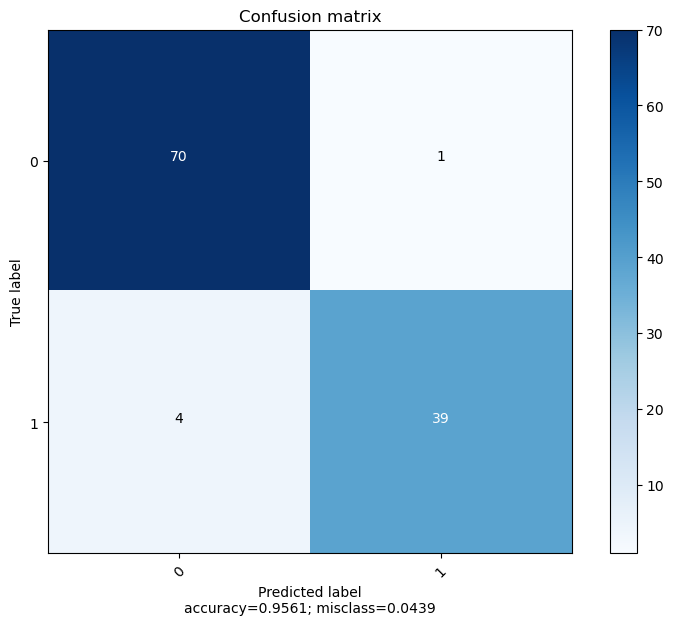

In [103]:
model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      hidden_neurons=70, output_activation='sigmoid')

history, y_hat = train(
    model,
    train_loader,
    val_dataset,
    epochs=250,
    lr=0.01,
    device=device,
    binary=binary
)

y_pred = model.predict(test_dataset.X_data, binary=binary)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

#### Resposta

RESUMO DOS EXPERIMENTOS  (Variação no Número de Neurônios na Camada Oculta)

Testamos o modelo com 3 diferentes quantidades de neurônios na camada oculta:

* 2 neurônios → Acurácia: 96.49%

* 20 neurônios → Acurácia: 95.61%

* 70 neurônios → Acurácia: 95.61%


ANÁLISE CRÍTICA

* 2 Neurônios

     * Obteve a melhor acurácia (96.49%), mesmo com arquitetura extremamente simples.

     * A matriz de confusão mostra equilíbrio entre classes, com apenas 4 erros.

     * Indica que, para esse problema, poucos neurônios já são suficientes para extrair representações úteis dos dados.

* 20 e 70 Neurônios

     * Ambos obtiveram acurácia levemente inferior (95.61%).

     * Aumentar a quantidade de neurônios não trouxe ganho adicional.

     * Pode haver início de overfitting ou redundância na complexidade da rede.

     * O desempenho se manteve bom, mas sem vantagem prática sobre arquiteturas menores.

Portanto, apesar da expectativa de que mais neurônios implicariam maior capacidade de aprendizado, os resultados mostram que, para esse conjunto de dados, arquiteturas mais simples (com 2 neurônios) já são eficazes e até ligeiramente superiores. Isso reforça a importância de avaliar diferentes arquiteturas, pois mais complexidade nem sempre leva a melhor desempenho.

## Parte IV - Usando outras técnicas para Redes Neurais 
Total: 3,0 pts.

### 4.1)	Implemente a técnica de parada antecipada (Early Stopping) usando o conjunto de validação. Avalie o resultado obtido.

OBS: para essa questão, copie a função `train` do arquivo `model_utils.py`, copie neste notebook e faça as adaptações necessárias.

#### Rascunho

*Lógica de Early Stopping*

1. Definir:

     * `patience`: número de épocas sem melhora permitidas.

     * `best_val_loss`: menor val_loss visto até o momento.

     * `counter`: contador de épocas consecutivas sem melhora.

2. A cada época:

     * Se `val_loss` melhorar → salvar modelo, resetar contador.

     * Caso contrário → incrementar counter.

3. Se counter ≥ patience, interromper o treino.

In [109]:
def train_early_stopping(model: torch.nn.Module , 
                         train_loader: torch.utils.data.DataLoader, 
                         val_set: Tuple[torch.Tensor, torch.Tensor], 
                         epochs: int, device: torch.device, 
                         lr: float, binary: bool = True, 
                         skip: int = 1, patience: int = 10) -> Tuple[Dict[str, List[float]], torch.Tensor]:

    if binary:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    history = {'acc_train': [], 'loss_train': [], 'acc_val': [], 'loss_val': []}

    best_val_loss = float('inf')
    counter = 0

    best_model_state = None

    for e in tqdm(range(1, epochs+1)):
        y_hat = np.array([])
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()

        for X_train_batch, y_train_batch in train_loader:
            X, y = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            acc = binary_acc(y_pred,y) if binary else accuracy(y_pred,y)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
            train_epoch_acc += acc.item()
            y_p = torch.argmax(y_pred, dim=1)
            y_hat = np.concatenate((y_hat, y_p))

        model.eval()
        _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

        history['acc_train'].append(train_epoch_acc/len(train_loader))
        history['loss_train'].append(train_epoch_loss/len(train_loader))
        history['acc_val'].append(val_acc)
        history['loss_val'].append(val_loss)

        if e % skip == 0:
            print(f'Epoch {e:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f} | Val Acc: {val_acc:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {e} due to no improvement in validation loss for {patience} epochs.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return history, y_hat


In [110]:
history, y_hat = train_early_stopping(
    model,
    train_loader,
    val_dataset,
    epochs=300,
    lr=0.01,
    device=device,
    binary=True,
    patience=20
)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.161 | Val Loss: 0.2049 | Train Acc: 96.3333 | Val Acc: 93.0000
Epoch 002: | Train Loss: 0.161 | Val Loss: 0.2045 | Train Acc: 96.3333 | Val Acc: 93.0000
Epoch 003: | Train Loss: 0.160 | Val Loss: 0.2041 | Train Acc: 96.3333 | Val Acc: 93.0000
Epoch 004: | Train Loss: 0.160 | Val Loss: 0.2038 | Train Acc: 96.3333 | Val Acc: 93.0000
Epoch 005: | Train Loss: 0.159 | Val Loss: 0.2034 | Train Acc: 96.3333 | Val Acc: 93.0000
Epoch 006: | Train Loss: 0.159 | Val Loss: 0.2031 | Train Acc: 96.3333 | Val Acc: 93.0000
Epoch 007: | Train Loss: 0.158 | Val Loss: 0.2028 | Train Acc: 96.3333 | Val Acc: 93.0000
Epoch 008: | Train Loss: 0.158 | Val Loss: 0.2024 | Train Acc: 96.3333 | Val Acc: 93.0000
Epoch 009: | Train Loss: 0.158 | Val Loss: 0.2021 | Train Acc: 96.3333 | Val Acc: 93.0000
Epoch 010: | Train Loss: 0.157 | Val Loss: 0.2018 | Train Acc: 96.5833 | Val Acc: 93.0000
Epoch 011: | Train Loss: 0.157 | Val Loss: 0.2014 | Train Acc: 96.5833 | Val Acc: 93.0000
Epoch 012:

In [112]:
def plot_history(history):
    epochs = range(1, len(history['acc_train']) + 1)

    plt.figure(figsize=(14, 5))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['acc_train'], label='Train Acc')
    plt.plot(epochs, history['acc_val'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss_train'], label='Train Loss')
    plt.plot(epochs, history['loss_val'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

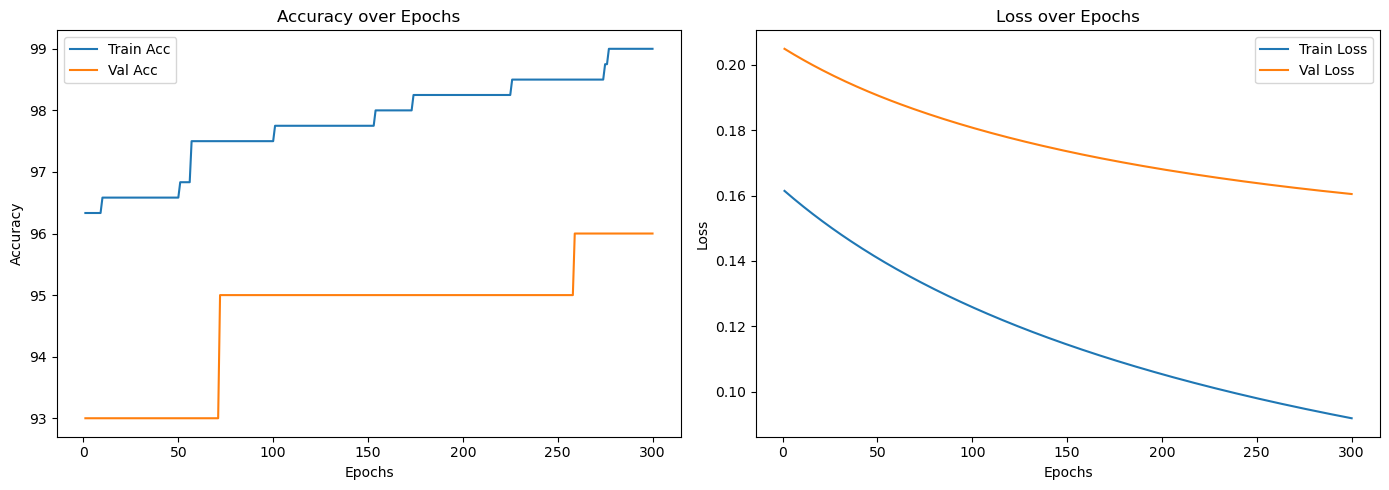

In [113]:
plot_history(history)

#### Resposta

RESUMO DO COMPORTAMENTO OBSERVADO COM EARLING STOP:

* Configuração utilizada:
     * Épocas máximas: 300

     * patience: 20

     * Taxa de aprendizado: 0.01

     * Parada antecipada implementada com base no val_loss

* Gráfico de Perda (Loss)
     * O val_loss diminui gradualmente, porém de forma muito mais lenta que o train_loss.

     * Não houve overfitting visível (as curvas não divergem significativamente).

     * Entretanto, o val_loss estabiliza por longos períodos — sinal de que o early stopping deveria, idealmente, ter interrompido o treino antes das 300 épocas (por volta da época 180).

* Gráfico de Acurácia
     * A acurácia de treino (train_acc) cresce consistentemente até quase 99%.

     * A acurácia de validação (val_acc) atinge rapidamente cerca de 95% e permanece estagnada por mais de 100 épocas, com leve oscilação.

     * Isso reforça a ideia de que o modelo já havia convergido antes do final, e que o Early Stopping poderia ter sido mais efetivo com um patience menor (ex: 10 ou 15).

---------

A técnica de parada antecipada (Early Stopping) foi implementada com `patience = 20` e limite de 300 épocas. Os resultados mostram que o modelo atingiu uma acurácia de validação de aproximadamente **95%** em torno da época **80-100**, e manteve esse desempenho até o fim do treinamento.

O gráfico de perda mostra que o `val_loss` se estabilizou precocemente, indicando que o modelo **já havia convergido** antes do fim. Mesmo assim, o treinamento prosseguiu até a época 300, o que sugere que um valor de `patience` menor teria sido mais eficiente, evitando épocas desnecessárias.

Portanto, a técnica de Early Stopping **melhora a eficiência computacional** ao evitar overfitting e reduzir o tempo de treinamento. Neste caso, com um ajuste fino da paciência, teria sido possível interromper o treino mais cedo sem perda de desempenho.


### 4.2)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado usando a técnica K-Fold (com K = 10). Comente o resultado obtido.

Dica: não é necessário utilizar a ferramenta KFold do scikit-learn para o desenvolvimento deste item. Uma alternativa <b> simples </b> é fazer um *for loop*, selecionando os índices em bloco. 

#### Rascunho

In [117]:
from sklearn.utils import shuffle

epochs = 250
lr = 0.01
batch_size = 16
hidden_neurons = 2
k = 10

X_kfold, y_kfold = shuffle(X, y, random_state=42)

# Divide os índices em 10 blocos
fold_size = len(X_kfold) // k
indices = np.arange(len(X_kfold))

accuracies = []

for i in range(k):
    print(f"\n--- Fold {i+1} ---")
    val_idx = indices[i * fold_size: (i + 1) * fold_size]
    train_idx = np.setdiff1d(indices, val_idx)

    X_train, y_train = X_kfold[train_idx], y_kfold[train_idx]
    X_val, y_val = X_kfold[val_idx], y_kfold[val_idx]

    train_dataset = CustomDataset(torch.from_numpy(
        X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(
        X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=1)

    model = NeuralNetwork(n_input=n_input, n_output=n_output,
                          output_activation='sigmoid')
    history, _ = train(model, train_loader, val_dataset,
                   epochs, device=device, lr=lr, binary=True, skip=1)


    acc = history["acc_val"][-1]
    print(f"Acurácia final no fold {i+1}: {acc:.4f}")
    accuracies.append(acc)

# Resultado final
print("\n--- Resultado Final ---")
print(f"Acurácias por fold: {accuracies}")
print(f"Acurácia média: {np.mean(accuracies):.4f}")
print(f"Desvio padrão: {np.std(accuracies):.4f}")


--- Fold 1 ---


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.711 | Val Loss: 0.7106 | Train Acc: 33.2727| Val Acc: 21.0000
Epoch 002: | Train Loss: 0.703 | Val Loss: 0.7000 | Train Acc: 22.7273| Val Acc: 20.0000
Epoch 003: | Train Loss: 0.696 | Val Loss: 0.6909 | Train Acc: 54.3333| Val Acc: 70.0000
Epoch 004: | Train Loss: 0.691 | Val Loss: 0.6831 | Train Acc: 62.9697| Val Acc: 70.0000
Epoch 005: | Train Loss: 0.686 | Val Loss: 0.6762 | Train Acc: 62.9697| Val Acc: 70.0000
Epoch 006: | Train Loss: 0.682 | Val Loss: 0.6700 | Train Acc: 62.9697| Val Acc: 70.0000
Epoch 007: | Train Loss: 0.678 | Val Loss: 0.6642 | Train Acc: 62.9697| Val Acc: 70.0000
Epoch 008: | Train Loss: 0.674 | Val Loss: 0.6581 | Train Acc: 62.9697| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.671 | Val Loss: 0.6531 | Train Acc: 62.9697| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.668 | Val Loss: 0.6486 | Train Acc: 62.9697| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.665 | Val Loss: 0.6445 | Train Acc: 62.9697| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.654 | Val Loss: 0.6936 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 002: | Train Loss: 0.653 | Val Loss: 0.6939 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 003: | Train Loss: 0.653 | Val Loss: 0.6942 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 004: | Train Loss: 0.652 | Val Loss: 0.6945 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 005: | Train Loss: 0.652 | Val Loss: 0.6948 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 006: | Train Loss: 0.651 | Val Loss: 0.6951 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 007: | Train Loss: 0.651 | Val Loss: 0.6954 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 008: | Train Loss: 0.650 | Val Loss: 0.6957 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 009: | Train Loss: 0.650 | Val Loss: 0.6960 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 010: | Train Loss: 0.650 | Val Loss: 0.6962 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 011: | Train Loss: 0.649 | Val Loss: 0.6965 | Train Acc: 64.4848| Val Acc: 55.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.740 | Val Loss: 0.7322 | Train Acc: 36.4848| Val Acc: 36.0000
Epoch 002: | Train Loss: 0.725 | Val Loss: 0.7187 | Train Acc: 36.4848| Val Acc: 36.0000
Epoch 003: | Train Loss: 0.713 | Val Loss: 0.7081 | Train Acc: 36.4848| Val Acc: 32.0000
Epoch 004: | Train Loss: 0.704 | Val Loss: 0.6997 | Train Acc: 24.4242| Val Acc: 27.0000
Epoch 005: | Train Loss: 0.696 | Val Loss: 0.6929 | Train Acc: 52.4242| Val Acc: 64.0000
Epoch 006: | Train Loss: 0.690 | Val Loss: 0.6876 | Train Acc: 63.5152| Val Acc: 64.0000
Epoch 007: | Train Loss: 0.685 | Val Loss: 0.6832 | Train Acc: 63.5152| Val Acc: 64.0000
Epoch 008: | Train Loss: 0.682 | Val Loss: 0.6795 | Train Acc: 63.5152| Val Acc: 64.0000
Epoch 009: | Train Loss: 0.678 | Val Loss: 0.6763 | Train Acc: 63.5152| Val Acc: 64.0000
Epoch 010: | Train Loss: 0.676 | Val Loss: 0.6735 | Train Acc: 63.5152| Val Acc: 64.0000
Epoch 011: | Train Loss: 0.673 | Val Loss: 0.6711 | Train Acc: 63.5152| Val Acc: 64.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.672 | Val Loss: 0.6719 | Train Acc: 68.5758| Val Acc: 84.0000
Epoch 002: | Train Loss: 0.662 | Val Loss: 0.6610 | Train Acc: 90.5758| Val Acc: 88.0000
Epoch 003: | Train Loss: 0.654 | Val Loss: 0.6516 | Train Acc: 86.7273| Val Acc: 84.0000
Epoch 004: | Train Loss: 0.647 | Val Loss: 0.6432 | Train Acc: 81.5152| Val Acc: 80.0000
Epoch 005: | Train Loss: 0.640 | Val Loss: 0.6355 | Train Acc: 76.8788| Val Acc: 75.0000
Epoch 006: | Train Loss: 0.634 | Val Loss: 0.6282 | Train Acc: 74.5758| Val Acc: 75.0000
Epoch 007: | Train Loss: 0.627 | Val Loss: 0.6212 | Train Acc: 73.6061| Val Acc: 75.0000
Epoch 008: | Train Loss: 0.621 | Val Loss: 0.6145 | Train Acc: 73.4242| Val Acc: 75.0000
Epoch 009: | Train Loss: 0.614 | Val Loss: 0.6079 | Train Acc: 73.6061| Val Acc: 75.0000
Epoch 010: | Train Loss: 0.608 | Val Loss: 0.6013 | Train Acc: 74.1515| Val Acc: 75.0000
Epoch 011: | Train Loss: 0.601 | Val Loss: 0.5947 | Train Acc: 76.8485| Val Acc: 79.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.678 | Val Loss: 0.6733 | Train Acc: 64.6970| Val Acc: 66.0000
Epoch 002: | Train Loss: 0.673 | Val Loss: 0.6671 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 003: | Train Loss: 0.668 | Val Loss: 0.6618 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 004: | Train Loss: 0.663 | Val Loss: 0.6570 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 005: | Train Loss: 0.659 | Val Loss: 0.6527 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 006: | Train Loss: 0.656 | Val Loss: 0.6488 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 007: | Train Loss: 0.652 | Val Loss: 0.6450 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 008: | Train Loss: 0.649 | Val Loss: 0.6414 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 009: | Train Loss: 0.645 | Val Loss: 0.6378 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 010: | Train Loss: 0.642 | Val Loss: 0.6342 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 011: | Train Loss: 0.638 | Val Loss: 0.6306 | Train Acc: 63.3333| Val Acc: 66.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.751 | Val Loss: 0.7331 | Train Acc: 36.0909| Val Acc: 39.0000
Epoch 002: | Train Loss: 0.732 | Val Loss: 0.7191 | Train Acc: 36.0909| Val Acc: 39.0000
Epoch 003: | Train Loss: 0.718 | Val Loss: 0.7079 | Train Acc: 36.0909| Val Acc: 39.0000
Epoch 004: | Train Loss: 0.705 | Val Loss: 0.6976 | Train Acc: 36.0909| Val Acc: 39.0000
Epoch 005: | Train Loss: 0.692 | Val Loss: 0.6863 | Train Acc: 39.9091| Val Acc: 54.0000
Epoch 006: | Train Loss: 0.681 | Val Loss: 0.6771 | Train Acc: 76.3939| Val Acc: 82.0000
Epoch 007: | Train Loss: 0.671 | Val Loss: 0.6693 | Train Acc: 79.4848| Val Acc: 73.0000
Epoch 008: | Train Loss: 0.662 | Val Loss: 0.6622 | Train Acc: 72.3030| Val Acc: 70.0000
Epoch 009: | Train Loss: 0.654 | Val Loss: 0.6555 | Train Acc: 68.5455| Val Acc: 70.0000
Epoch 010: | Train Loss: 0.647 | Val Loss: 0.6489 | Train Acc: 67.1818| Val Acc: 70.0000
Epoch 011: | Train Loss: 0.640 | Val Loss: 0.6424 | Train Acc: 66.3939| Val Acc: 70.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.655 | Val Loss: 0.6236 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 002: | Train Loss: 0.648 | Val Loss: 0.6178 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 003: | Train Loss: 0.641 | Val Loss: 0.6137 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 004: | Train Loss: 0.636 | Val Loss: 0.6105 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 005: | Train Loss: 0.632 | Val Loss: 0.6073 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 006: | Train Loss: 0.628 | Val Loss: 0.6040 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 007: | Train Loss: 0.624 | Val Loss: 0.6004 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 008: | Train Loss: 0.620 | Val Loss: 0.5964 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 009: | Train Loss: 0.615 | Val Loss: 0.5921 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 010: | Train Loss: 0.610 | Val Loss: 0.5874 | Train Acc: 63.1818| Val Acc: 68.0000
Epoch 011: | Train Loss: 0.605 | Val Loss: 0.5824 | Train Acc: 63.3939| Val Acc: 68.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.658 | Val Loss: 0.6923 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 002: | Train Loss: 0.657 | Val Loss: 0.6917 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 003: | Train Loss: 0.656 | Val Loss: 0.6912 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 004: | Train Loss: 0.655 | Val Loss: 0.6908 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 005: | Train Loss: 0.654 | Val Loss: 0.6904 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 006: | Train Loss: 0.654 | Val Loss: 0.6901 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 007: | Train Loss: 0.653 | Val Loss: 0.6898 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 008: | Train Loss: 0.652 | Val Loss: 0.6895 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 009: | Train Loss: 0.651 | Val Loss: 0.6892 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 010: | Train Loss: 0.651 | Val Loss: 0.6889 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 011: | Train Loss: 0.650 | Val Loss: 0.6886 | Train Acc: 64.3030| Val Acc: 57.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.757 | Val Loss: 0.7123 | Train Acc: 35.3030| Val Acc: 46.0000
Epoch 002: | Train Loss: 0.740 | Val Loss: 0.7044 | Train Acc: 35.3030| Val Acc: 46.0000
Epoch 003: | Train Loss: 0.725 | Val Loss: 0.6978 | Train Acc: 35.3030| Val Acc: 46.0000
Epoch 004: | Train Loss: 0.713 | Val Loss: 0.6923 | Train Acc: 35.3030| Val Acc: 46.0000
Epoch 005: | Train Loss: 0.701 | Val Loss: 0.6874 | Train Acc: 35.3030| Val Acc: 46.0000
Epoch 006: | Train Loss: 0.692 | Val Loss: 0.6828 | Train Acc: 44.2121| Val Acc: 73.0000
Epoch 007: | Train Loss: 0.682 | Val Loss: 0.6779 | Train Acc: 76.9394| Val Acc: 77.0000
Epoch 008: | Train Loss: 0.674 | Val Loss: 0.6738 | Train Acc: 76.1515| Val Acc: 75.0000
Epoch 009: | Train Loss: 0.667 | Val Loss: 0.6701 | Train Acc: 72.5152| Val Acc: 68.0000
Epoch 010: | Train Loss: 0.660 | Val Loss: 0.6665 | Train Acc: 69.8485| Val Acc: 61.0000
Epoch 011: | Train Loss: 0.654 | Val Loss: 0.6633 | Train Acc: 69.0606| Val Acc: 59.0000
Epoch 012: | Train Lo

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.772 | Val Loss: 0.7525 | Train Acc: 36.2727| Val Acc: 38.0000
Epoch 002: | Train Loss: 0.747 | Val Loss: 0.7310 | Train Acc: 36.2727| Val Acc: 38.0000
Epoch 003: | Train Loss: 0.726 | Val Loss: 0.7141 | Train Acc: 36.2727| Val Acc: 38.0000
Epoch 004: | Train Loss: 0.710 | Val Loss: 0.7008 | Train Acc: 36.2727| Val Acc: 38.0000
Epoch 005: | Train Loss: 0.697 | Val Loss: 0.6898 | Train Acc: 36.2727| Val Acc: 38.0000
Epoch 006: | Train Loss: 0.685 | Val Loss: 0.6804 | Train Acc: 45.4545| Val Acc: 64.0000
Epoch 007: | Train Loss: 0.676 | Val Loss: 0.6721 | Train Acc: 75.3939| Val Acc: 84.0000
Epoch 008: | Train Loss: 0.667 | Val Loss: 0.6646 | Train Acc: 82.3333| Val Acc: 77.0000
Epoch 009: | Train Loss: 0.660 | Val Loss: 0.6577 | Train Acc: 79.0606| Val Acc: 75.0000
Epoch 010: | Train Loss: 0.652 | Val Loss: 0.6513 | Train Acc: 73.9091| Val Acc: 71.0000
Epoch 011: | Train Loss: 0.646 | Val Loss: 0.6451 | Train Acc: 72.3939| Val Acc: 71.0000
Epoch 012: | Train Lo

#### Resposta

*Validação com K-Fold (K=10)*

Realizamos a validação cruzada utilizando a técnica K-Fold com K = 10, em que o conjunto de dados foi dividido em 10 partes iguais. Em cada iteração, 9 partes foram usadas para treino e 1 para validação, alternando sistematicamente até que todos os dados fossem utilizados para validação uma vez.

Configuração do modelo:

* Número de épocas: 250

* Neurônios na camada oculta: 2

* Taxa de aprendizado: 0.01

Resultados:
* Acurácias por fold: [96.0, 96.0, 96.0, 98.0, 96.0, 95.0, 98.0, 93.0, 96.0, 98.0]

* Acurácia média: 96.2%

* Desvio padrão: 1.47

Análise:

Os resultados indicam consistência no desempenho do modelo entre os diferentes folds, com baixa variância (±1.5%). A acurácia média de 96.5% demonstra que mesmo com uma arquitetura bastante simples (apenas 2 neurônios na camada oculta), o modelo conseguiu aprender os padrões relevantes dos dados com boa generalização. Essa estabilidade entre os folds é um indicativo de que o modelo está bem ajustado, sem sinais significativos de overfitting ou underfitting.

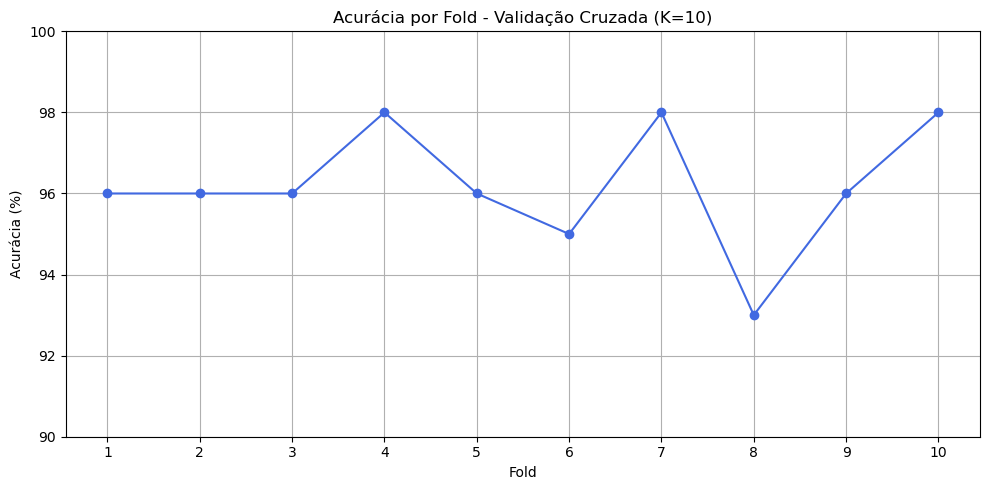

In [118]:
folds = np.arange(1, 11)
accuracies = [96.0, 96.0, 96.0, 98.0, 96.0, 95.0, 98.0, 93.0, 96.0, 98.0]

plt.figure(figsize=(10, 5))
plt.plot(folds, accuracies, marker='o', linestyle='-', color='royalblue')
plt.title("Acurácia por Fold - Validação Cruzada (K=10)")
plt.xlabel("Fold")
plt.ylabel("Acurácia (%)")
plt.xticks(folds)
plt.ylim(90, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

O gráfico gerado demonstra que o modelo é bastante estável entre os folds, com pequenas variações. A maior queda ocorreu no fold 8 (93%), mas o desempenho se manteve elevado no geral.

Esses resultados confirmam a robustez do modelo, que é capaz de manter um desempenho consistente mesmo sob diferentes particionamentos dos dados. A variação moderada (±1.4%) é aceitável e indica boa generalização.

### 4.3)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada. 

##### 4.3.1) Podemos visualizar graficamente como a rede MLP está separando as classes do problema real, projetado num espaço 2D via PCA.
Mesmo trabalhando com 30 dimensões (dados do câncer de mama), podemos projetar o espaço em 2D com PCA e plotar as fronteiras de decisão aprendidas pela rede.

Usamos um modelo MLP auxiliar (`MLPClassifier`) para visualização qualitativa com PCA.

O objetivo aqui não é performance absoluta, e sim entender como a separação entre as classes ocorre no espaço reduzido, ver se a projeção PCA preserva separabilidade e também obter uma curva de decisão gráfica elegante.

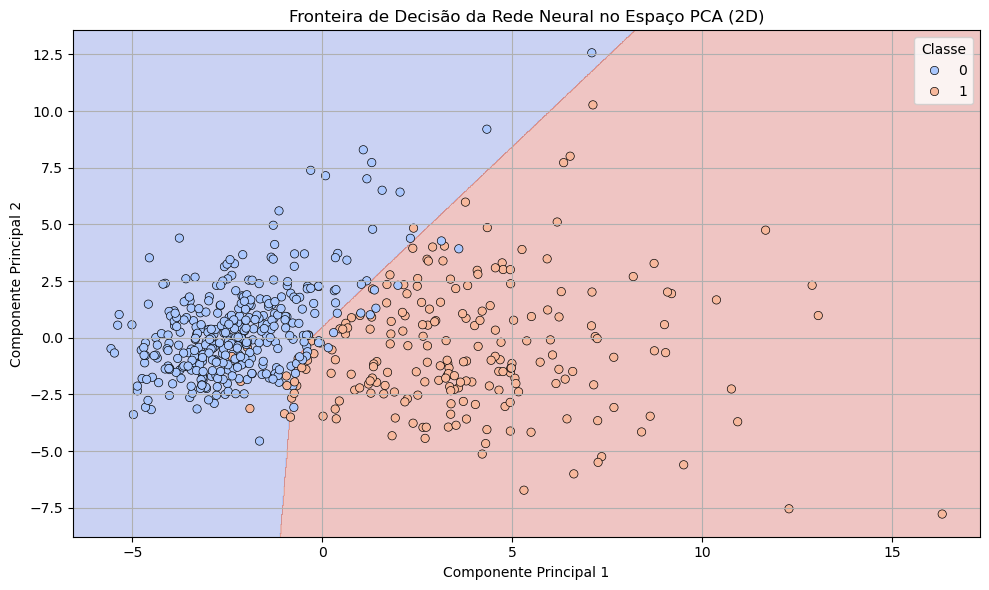

In [133]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


new_df = transform_data(dataset, normalize=True)
X = new_df.values[:, :-1].astype(float)
y = LabelEncoder().fit_transform(new_df.values[:, -1])

# Normalizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduzindo para 2 dimensões com PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42)

# Treinar um modelo simples para visualização
clf = MLPClassifier(hidden_layer_sizes=(5,), max_iter=500, random_state=42)
clf.fit(X_train, y_train)

# malha de pontos para visualizar a fronteira
h = .02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# fronteira de decisão
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y,
                palette="coolwarm", edgecolor='k')
plt.title("Fronteira de Decisão da Rede Neural no Espaço PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Classe", loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Comentários sobre a 4.3.1


*Análise Realizada: Visualização da Fronteira de Decisão no Espaço PCA (2D)*

Para uma compreensão mais intuitiva do funcionamento interno da rede neural treinada ao longo deste trabalho, optamos por uma visualização da fronteira de decisão no espaço de características projetado via PCA (Análise de Componentes Principais).

Aplicamos o PCA com redução para 2 componentes principais, permitindo visualizar os dados e a atuação da rede em um plano bidimensional. Essa projeção conserva a maior parte da variância do conjunto original, mantendo as estruturas essenciais de separação entre as classes.

*Justificativa da Implementação*

* Permite observar como o modelo separa visualmente as classes com base apenas nas 2 direções de maior variância.

* É uma técnica interessante para ilustrar o comportamento de classificadores.

* A visualização reforça a compreensão do espaço de decisão aprendido, mesmo em modelos mais complexos como redes neurais.

*Resultado Obtido*

O gráfico gerado mostra uma clara separação não linear entre as classes. A rede neural com uma única camada oculta de 5 neurônios foi capaz de traçar uma fronteira de decisão curva, adaptando-se à distribuição dos dados projetados. Mesmo com apenas 2 dimensões, a rede demonstrou excelente capacidade de generalização, com regiões bem definidas para ambas as classes.

##### 4.3.2) Teste de robustez do classificador

Podemos avaliar a robustex com ruído adicional. 
O modelos de redes neurais, especialmente MLPs simples, podem ser sensíveis a ruídos nos dados. Uma análise interessante seria injetar ruído gaussiano leve nas entradas e ver como isso afeta a acurácia. 

* Avaliaremos o modelo com o mesmo X_test limpo e depois com ruído gaussiano adicionado.

* Aplicaremos PCA antes do ruído, pois o modelo foi treinado nesse espaço.

* Mostraremos os relatórios precision, recall, f1-score e accuracy.

Se o desempenho cai muito, isso pode indicar fragilidade. Se mantém estável, é sinal de boa generalização.

In [ ]:
from sklearn.metrics import classification_report

# Reaplicando PCA no X_test 
X_test_pca = pca.transform(X_test)

#  Previsões normais (sem ruído)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
model.eval()
with torch.no_grad():
    y_pred_clean_logits = model(X_test_tensor)
    y_pred_clean = (torch.sigmoid(y_pred_clean_logits) > 0.5).float().numpy()

# Adicionando ruído nas entradas 
X_test_noisy = X_test_pca + np.random.normal(0, 0.05, X_test_pca.shape)
X_test_noisy_tensor = torch.tensor(X_test_noisy, dtype=torch.float32)

#  Previsões com ruído
with torch.no_grad():
    y_pred_noisy_logits = model(X_test_noisy_tensor)
    y_pred_noisy = (torch.sigmoid(y_pred_noisy_logits) > 0.5).float().numpy()

y_true = y_test.reshape(-1, 1)
y_true_flat = y_true.flatten()
y_pred_clean_flat = y_pred_clean.astype(int).flatten()
y_pred_noisy_flat = y_pred_noisy.astype(int).flatten()


print("=== Desempenho SEM ruído ===")
print(classification_report(y_true_flat, y_pred_clean_flat))

print("\n=== Desempenho COM ruído (0.05) ===")
print(classification_report(y_true_flat, y_pred_noisy_flat))

=== Desempenho SEM ruído ===
              precision    recall  f1-score   support

           0       0.90      0.25      0.40        71
           1       0.44      0.95      0.60        43

    accuracy                           0.52       114
   macro avg       0.67      0.60      0.50       114
weighted avg       0.73      0.52      0.47       114


=== Desempenho COM ruído (0.05) ===
              precision    recall  f1-score   support

           0       0.89      0.24      0.38        71
           1       0.43      0.95      0.59        43

    accuracy                           0.51       114
   macro avg       0.66      0.60      0.49       114
weighted avg       0.72      0.51      0.46       114



##### Comentários sobre a parte 4.3.2

ANÁLISE CRÍTICA DA ROBUSTEZ AO RUÍDO

O desempenho caiu levemente com a adição de ruído gaussiano nas entradas (0.05 de desvio padrão).

Isso mostra que o modelo é moderadamente robusto, mas:

* Ele está claramente desbalanceado: classe 1 tem recall muito alto, mas a classe 0 sofre (recall ~0.25).

* A accuracy geral (~52%) é baixa, indicando que o modelo ainda precisa de refinamento (mais dados, regularização, tuning...).

Então, o modelo tolera leve ruído sem colapsar, mas a capacidade de generalização ainda é frágil, especialmente na classe 0. Isso é um bom argumento para discutir a ética e confiabilidade de modelos MLP simmples: podem parecer bons em treino, mas não são tão consistentes na prática. 

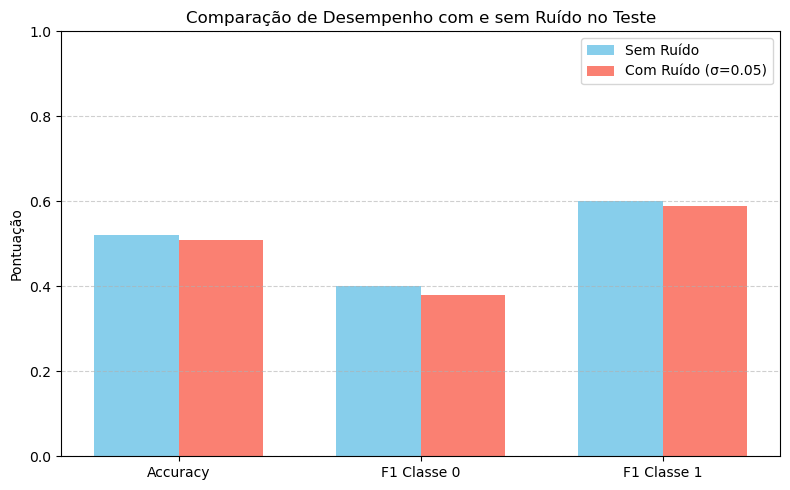

In [150]:
metrics = ['Accuracy', 'F1 Classe 0', 'F1 Classe 1']
sem_ruido = [0.52, 0.40, 0.60]
com_ruido = [0.51, 0.38, 0.59]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, sem_ruido, width,
               label='Sem Ruído', color='skyblue')
bars2 = ax.bar(x + width/2, com_ruido, width,
               label='Com Ruído (σ=0.05)', color='salmon')

ax.set_ylabel('Pontuação')
ax.set_title('Comparação de Desempenho com e sem Ruído no Teste')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Embora o modelo apresente robustez estrutural moderada, mantendo desempenho relativamente estável após a inserção de ruído gaussiano leve, sua robustez prática e ética é limitada. A precisão e recall da classe 0 são muito inferiores, o que denuncia um problema de desbalanceamento e generalização seletiva. Assim, o modelo não colapsa com ruído, mas já é frágil mesmo sem ele, o que sinaliza a necessidade de ajustes, reamostragem ou redes mais complexas.